# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

Sampling rewards from each arm:
Arm 0: mean=0.967, max=3.980
Arm 1: mean=0.652, max=3.253
Arm 2: mean=1.016, max=3.501


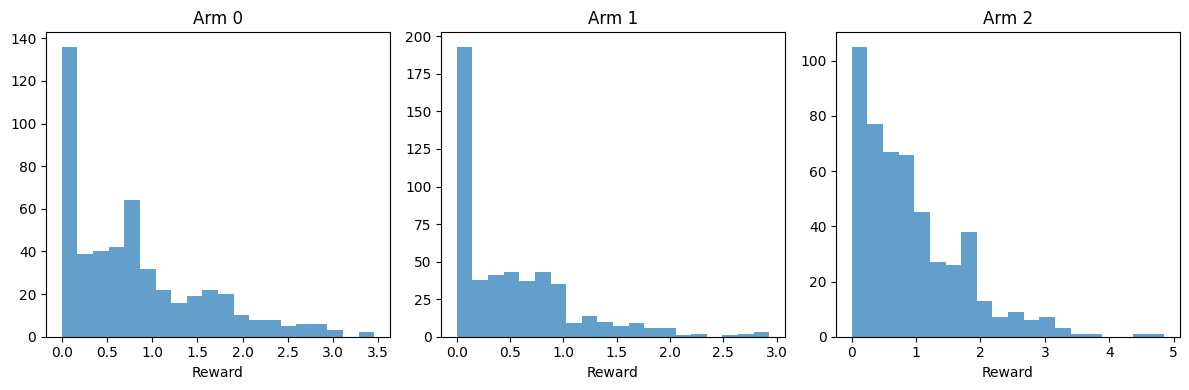

In [5]:
# YOUR CHANGES HERE

import matplotlib.pyplot as plt

# Explore the bandit with seed 0
bandit0 = BanditProblem(0)

# Sample rewards to understand distributions
print("Sampling rewards from each arm:")
for arm in range(3):
    rewards = [bandit0.get_reward(arm) for _ in range(100)]
    print(f"Arm {arm}: mean={np.mean(rewards):.3f}, max={np.max(rewards):.3f}")

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for arm in range(3):
    rewards = [bandit0.get_reward(arm) for _ in range(500)]
    axes[arm].hist(rewards, bins=20, alpha=0.7)
    axes[arm].set_title(f'Arm {arm}')
    axes[arm].set_xlabel('Reward')

plt.tight_layout()
plt.show()



Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

In [ ]:
# YOUR CHANGES HERE

class UCB1:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 0
        
    def select_arm(self):
        if self.t < self.num_arms:
            return self.t
        
        ucb_values = self.values + np.sqrt(2 * np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# Run simulation with seed 2025002
bandit = BanditProblem(2025002)
algorithm = UCB1(bandit.get_num_arms())


Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [16]:
# YOUR CHANGES HERE
import pandas as pd

history = []

for trial in range(1000):
    action = algorithm.select_arm()
    reward = bandit.get_reward(action)
    algorithm.update(action, reward)
    
    history.append((action, reward))

with open('history.tsv', 'w') as f:
    f.write('action\treward\n')
    for action, reward in history:
        f.write(f'{action}\t{reward}\n')

history_df = pd.read_csv('history.tsv', sep='\t')
print(history_df)

     action    reward
0         0  0.451736
1         0  0.728219
2         0  0.556216
3         0  1.917412
4         0  0.747736
..      ...       ...
995       0  0.000000
996       0  0.974435
997       0  0.368857
998       0  0.000000
999       1  0.786720

[1000 rows x 2 columns]


Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [ ]:
# YOUR CHANGES HERE

history_df = pd.read_csv('history.tsv', sep='\t')

action_stats = []

for arm in range(3):  # We know there are 3 arms
    arm_rewards = history_df[history_df['action'] == arm]['reward']
    
    if len(arm_rewards) > 0:
        min_reward = arm_rewards.min()
        mean_reward = arm_rewards.mean()
        max_reward = arm_rewards.max()
        
        action_stats.append({
            'action': arm,
            'min_reward': min_reward,
            'mean_reward': mean_reward,
            'max_reward': max_reward
        })
    else:
        action_stats.append({
            'action': arm,
            'min_reward': 0,
            'mean_reward': 0,
            'max_reward': 0
        })

stats_df = pd.DataFrame(action_stats)
stats_df.to_csv('actions.tsv', sep='\t', index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [20]:
def estimate_true_rewards(seed=2025002, samples_per_arm=10000):
    """Estimate true expected rewards for each arm"""
    bandit = BanditProblem(seed)
    true_rewards = []
    
    for arm in range(bandit.get_num_arms()):
        rewards = [bandit.get_reward(arm) for _ in range(samples_per_arm)]
        true_rewards.append(np.mean(rewards))
        print(f"Arm {arm} estimated true mean: {np.mean(rewards):.4f}")
    
    return np.array(true_rewards)

def calculate_regret(true_rewards, arm_selections, rewards_obtained):
    """Calculate regret for a given strategy"""
    optimal_reward_per_step = np.max(true_rewards)
    total_optimal_reward = optimal_reward_per_step * len(arm_selections)
    total_actual_reward = np.sum(rewards_obtained)
    regret = total_optimal_reward - total_actual_reward
    return regret

true_rewards = estimate_true_rewards()

history_df = pd.read_csv('history.tsv', sep='\t')
actual_actions = history_df['action'].values
actual_rewards = history_df['reward'].values

results = []

# 1. Actual UCB1 strategy
actual_regret = calculate_regret(true_rewards, actual_actions, actual_rewards)
results.append(('actual', actual_regret))

bandit = BanditProblem(2025002)
np.random.seed(42)
uniform_actions = np.random.randint(0, 3, 1000)
uniform_rewards = [bandit.get_reward(action) for action in uniform_actions]
uniform_regret = calculate_regret(true_rewards, uniform_actions, uniform_rewards)
results.append(('uniform', uniform_regret))

for arm in range(3):
    bandit = BanditProblem(2025002)
    just_actions = [arm] * 1000
    just_rewards = [bandit.get_reward(arm) for _ in range(1000)]
    regret = calculate_regret(true_rewards, just_actions, just_rewards)
    results.append((f'just-{arm}', regret))

strategies_df = pd.DataFrame(results, columns=['strategy', 'regret'])
strategies_df.to_csv('strategies.tsv', sep='\t', index=False)

print(strategies_df)

Arm 0 estimated true mean: 0.5713
Arm 1 estimated true mean: 0.5449
Arm 2 estimated true mean: 0.2004
  strategy      regret
0   actual   33.354073
1  uniform  122.881316
2   just-0    4.510503
3   just-1   30.817123
4   just-2  370.532197


Write your results to a file "strategies.tsv" with the columns strategy and regret.

Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.